<a href="https://colab.research.google.com/github/togich/vibrodiagnostic/blob/main/togich_team_example_DWT_discrete_wavelet_transform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Антон Журавлев. Применение дискретного вейвлет-преобразования для анализа сигналов датчика вибрации винотового компрессора

In [32]:
# Просто скачать файл
!wget -q -O /content/sampledata/dataset.csv "https://raw.githubusercontent.com/togich/vibrodiagnostic/main/К650RAW_accelerate_all_axes.csv"

print("✅ Файл загружен")

/content/sampledata/dataset.csv: No such file or directory
✅ Файл загружен


In [2]:
# @title 1. Установка необходимых библиотек
!pip install pywavelets -q
!pip install seaborn -q

# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import seaborn as sns
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Библиотеки успешно импортированы!")

Библиотеки успешно импортированы!


In [3]:

# @title 2. Загрузка данных из указанного пути

# Путь к файлу (используем ваш путь)
file_path = "/content/sample_data/compressor_data/К650RAW_accelerate_all_axes.csv"

# Проверка существования файла
import os
if os.path.exists(file_path):
    print(f"Файл найден: {file_path}")
    file_name = os.path.basename(file_path)
    print(f"Имя файла: {file_name}")
else:
    print(f"Файл не найден: {file_path}")
    print("\nДоступные файлы в директории /content/sample_data/compressor_data/:")
    try:
        files = os.listdir("/content/sample_data/compressor_data/")
        for f in files:
            print(f"  - {f}")
    except:
        print("Директория не найдена")

    # Альтернатива: загрузка через интерфейс
    print("\nПопробуем загрузить файл через интерфейс...")
    from google.colab import files
    uploaded = files.upload()
    if uploaded:
        file_name = list(uploaded.keys())[0]
        file_path = file_name
        print(f"Файл '{file_name}' успешно загружен!")
    else:
        print("Файл не загружен. Пожалуйста, проверьте путь.")

# Функция загрузки данных
def load_acceleration_data(file_path, display_info=True):
    """
    Загрузка данных ускорения из CSV файла
    Формат: Acceleration_MPerS2_1X,Acceleration_MPerS2_1Y,Acceleration_MPerS2_1Z,
            Acceleration_MPerS2_2X,Acceleration_MPerS2_2Y,Acceleration_MPerS2_2Z
    Разделитель десятичной части: запятая
    Разделитель столбцов: точка с запятой
    """
    try:
        # Пробуем загрузить данные с указанными разделителями
        df = pd.read_csv(file_path, sep=';', decimal=',')

        # Если не получилось, пробуем другие варианты разделителей
        if len(df.columns) == 1:
            print("Предполагаемый разделитель ';' не сработал, пробуем ','...")
            df = pd.read_csv(file_path, sep=',', decimal='.')

        if display_info:
            print("="*60)
            print("ИНФОРМАЦИЯ О ЗАГРУЖЕННЫХ ДАННЫХ:")
            print("="*60)
            print(f"Файл: {os.path.basename(file_path)}")
            print(f"Размер файла: {os.path.getsize(file_path) / 1024:.1f} KB")
            print(f"Количество строк: {len(df)}")
            print(f"Количество столбцов: {len(df.columns)}")
            print(f"\nСтолбцы:")
            for i, col in enumerate(df.columns, 1):
                print(f"  {i:2}. {col}")

            # Проверяем, есть ли ожидаемые столбцы
            expected_cols = ['Acceleration_MPerS2_1X', 'Acceleration_MPerS2_1Y',
                           'Acceleration_MPerS2_1Z', 'Acceleration_MPerS2_2X',
                           'Acceleration_MPerS2_2Y', 'Acceleration_MPerS2_2Z']

            missing_cols = [col for col in expected_cols if col not in df.columns]
            if missing_cols:
                print(f"\nВНИМАНИЕ: Отсутствуют ожидаемые столбцы:")
                for col in missing_cols:
                    print(f"  - {col}")
                print(f"\nИспользуем доступные столбцы с 'Acceleration' в названии")

            print(f"\nПервые 5 строк данных:")
            display(df.head())

            print(f"\nПоследние 5 строк данных:")
            display(df.tail())

            print(f"\nОсновная статистика:")
            print(df.describe().round(3))

            print(f"\nПроверка на пропущенные значения:")
            missing = df.isnull().sum()
            has_missing = False
            for col, count in missing.items():
                if count > 0:
                    print(f"  {col}: {count} пропущенных значений")
                    has_missing = True
            if not has_missing:
                print("  Пропущенных значений не обнаружено")

        return df

    except Exception as e:
        print(f"Ошибка при загрузке файла: {e}")
        print("\nПопробуем определить формат файла...")

        # Читаем первые несколько строк для определения формата
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = [f.readline() for _ in range(5)]

        print("\nПервые строки файла:")
        for i, line in enumerate(lines, 1):
            print(f"{i}: {line.strip()}")

        raise Exception(f"Не удалось загрузить файл. Проверьте разделители.")

# Загружаем данные (если файл существует)
if os.path.exists(file_path):
    df = load_acceleration_data(file_path)
else:
    print("Файл не найден. Пожалуйста, проверьте путь и запустите ячейку снова.")
    # Создаем пустой DataFrame для продолжения работы
    df = pd.DataFrame()

Файл найден: /content/sample_data/compressor_data/К650RAW_accelerate_all_axes.csv
Имя файла: К650RAW_accelerate_all_axes.csv
ИНФОРМАЦИЯ О ЗАГРУЖЕННЫХ ДАННЫХ:
Файл: К650RAW_accelerate_all_axes.csv
Размер файла: 134.1 KB
Количество строк: 4096
Количество столбцов: 6

Столбцы:
   1. Acceleration_MPerS2_1X
   2. Acceleration_MPerS2_1Y
   3. Acceleration_MPerS2_1Z
   4. Acceleration_MPerS2_2X
   5. Acceleration_MPerS2_2Y
   6. Acceleration_MPerS2_2Z

Первые 5 строк данных:


Acceleration_MPerS2_1X  Acceleration_MPerS2_1Y  Acceleration_MPerS2_1Z  \
0                   -0.95                    3.89                   -8.72   
1                    1.52                    4.31                   -6.25   
2                    0.68                    3.30                   -2.49   
3                   -2.05                    3.31                   -4.94   
4                    0.67                    5.00                   -9.47   

   Acceleration_MPerS2_2X  Acceleration_MPerS2_2Y  Acceleration_MPerS2_2Z  
0                    0.94                   16.25                    4.38  
1                    4.45                   10.84                   -2.96  
2                    0.55                    3.53                    0.77  
3                   -1.73                    6.47                    2.88  
4                   -2.94                   15.87                   -0.60


Последние 5 строк данных:


Acceleration_MPerS2_1X  Acceleration_MPerS2_1Y  Acceleration_MPerS2_1Z  \
4091                   -2.95                    6.12                  -10.55   
4092                    0.99                    7.25                  -10.68   
4093                    0.50                    5.96                   -6.56   
4094                   -3.85                    6.00                  -10.01   
4095                   -1.68                    7.85                   -9.81   

      Acceleration_MPerS2_2X  Acceleration_MPerS2_2Y  Acceleration_MPerS2_2Z  
4091                    0.83                   11.54                   -4.43  
4092                   -7.58                    2.28                    1.18  
4093                   -3.76                   10.13                   -1.89  
4094                    4.16                   16.59                   -4.45  
4095                    2.37                   12.47                    4.33


Основная статистика:
       Acceleration_MPerS2_1X  Acceleration_MPerS2_1Y  Acceleration_MPerS2_1Z  \
count                4096.000                4096.000                4096.000   
mean                   -0.276                   5.371                  -7.923   
std                     1.426                   1.595                   2.582   
min                    -4.070                   1.220                 -13.050   
25%                    -1.470                   4.190                  -9.800   
50%                    -0.160                   5.270                  -8.425   
75%                     0.950                   6.420                  -6.698   
max                     2.820                  10.450                  -0.240   

       Acceleration_MPerS2_2X  Acceleration_MPerS2_2Y  Acceleration_MPerS2_2Z  
count                4096.000                4096.000                4096.000  
mean                   -0.037                   9.774                  -0.323  
std     

In [19]:
# @title 3. Настройка параметров анализа

# Параметры
SAMPLING_FREQUENCY = 200.0  # Частота дискретизации (Гц)
WAVELET_NAME = 'db4'        # Выбранный вейвлет
DWT_LEVEL = 4               # Уровень разложения

# Список доступных вейвлетов
print("Доступные семейства вейвлетов в PyWavelets:")
print("-" * 50)

# Группируем вейвлеты по семействам
wavelet_families = {}
for w in pywt.families():
    wavelet_families[w] = pywt.wavelist(w)

for family, wavelets in wavelet_families.items():
    print(f"{family.upper():15}: {', '.join(wavelets[:5])}{'...' if len(wavelets) > 5 else ''}")

print("\n" + "="*50)
print("ПАРАМЕТРЫ АНАЛИЗА:")
print("="*50)
print(f"Частота дискретизации: {SAMPLING_FREQUENCY} Гц")
print(f"Выбранный вейвлет: {WAVELET_NAME}")
print(f"Уровень разложения: {DWT_LEVEL}")

# Выбор каналов для анализа
print("\nДоступные каналы ускорения:")
acceleration_columns = [col for col in df.columns if 'Acceleration' in col]
for i, col in enumerate(acceleration_columns, 1):
    print(f"  {i:2}. {col}")

# По умолчанию анализируем первые 3 канала
channels_to_analyze = acceleration_columns[:3]
print(f"\nКаналы для анализа: {channels_to_analyze}")

Доступные семейства вейвлетов в PyWavelets:
--------------------------------------------------
HAAR           : haar
DB             : db1, db2, db3, db4, db5...
SYM            : sym2, sym3, sym4, sym5, sym6...
COIF           : coif1, coif2, coif3, coif4, coif5...
BIOR           : bior1.1, bior1.3, bior1.5, bior2.2, bior2.4...
RBIO           : rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4...
DMEY           : dmey
GAUS           : gaus1, gaus2, gaus3, gaus4, gaus5...
MEXH           : mexh
MORL           : morl
CGAU           : cgau1, cgau2, cgau3, cgau4, cgau5...
SHAN           : shan
FBSP           : fbsp
CMOR           : cmor

ПАРАМЕТРЫ АНАЛИЗА:
Частота дискретизации: 200.0 Гц
Выбранный вейвлет: db4
Уровень разложения: 4

Доступные каналы ускорения:
   1. Acceleration_MPerS2_1X
   2. Acceleration_MPerS2_1Y
   3. Acceleration_MPerS2_1Z
   4. Acceleration_MPerS2_2X
   5. Acceleration_MPerS2_2Y
   6. Acceleration_MPerS2_2Z

Каналы для анализа: ['Acceleration_MPerS2_1X', 'Acceleration_MPerS2

In [20]:
# @title 4. Функции для вейвлет-анализа

def perform_dwt_analysis(signal_data, wavelet_name='db4', level=5, fs=1.0):
    """
    Выполнение дискретного вейвлет-анализа сигнала
    """
    # Проверка длины сигнала
    if len(signal_data) < 2**level:
        print(f"Внимание: Длина сигнала ({len(signal_data)}) меньше 2^{level}.")
        level = int(np.log2(len(signal_data))) - 1
        print(f"Уровень разложения уменьшен до {level}")

    # Удаление NaN значений
    signal_clean = signal_data[~np.isnan(signal_data)]

    # Вычисление коэффициентов DWT
    coeffs = pywt.wavedec(signal_clean, wavelet_name, level=level, mode='symmetric')

    # Восстановление полного сигнала
    reconstructed = pywt.waverec(coeffs, wavelet_name, mode='symmetric')

    # Восстановление отдельных компонент
    components = {}
    components['approximation'] = pywt.upcoef('a', coeffs[0], wavelet_name,
                                            level=level, take=len(signal_clean))

    details = []
    for i in range(1, level + 1):
        detail = pywt.upcoef('d', coeffs[i], wavelet_name,
                           level=level + 1 - i, take=len(signal_clean))
        details.append(detail)
    components['details'] = details

    return {
        'coeffs': coeffs,
        'reconstructed': reconstructed,
        'components': components,
        'wavelet': wavelet_name,
        'level': level,
        'fs': fs,
        'signal_clean': signal_clean
    }

def calculate_energy_distribution(coeffs):
    """
    Расчет распределения энергии по уровням разложения
    """
    total_energy = sum([np.sum(c**2) for c in coeffs])

    energy_per_level = []
    percentages = []

    for i, c in enumerate(coeffs):
        level_energy = np.sum(c**2)
        energy_per_level.append(level_energy)
        percentages.append(level_energy / total_energy * 100)

    return energy_per_level, percentages, total_energy

def plot_original_signals(df, channels, fs=100.0, max_samples=1000):
    """
    Визуализация исходных сигналов
    """
    fig, axes = plt.subplots(len(channels), 1, figsize=(12, 3*len(channels)))

    if len(channels) == 1:
        axes = [axes]

    for idx, channel in enumerate(channels):
        signal_data = df[channel].values
        signal_clean = signal_data[~np.isnan(signal_data)]
        t = np.arange(len(signal_clean)) / fs

        # Берем только первые max_samples для наглядности
        plot_len = min(len(signal_clean), max_samples)

        ax = axes[idx]
        ax.plot(t[:plot_len], signal_clean[:plot_len], 'b-', linewidth=1, alpha=0.8)
        ax.set_xlabel('Время (с)')
        ax.set_ylabel('Ускорение (м/с²)')
        ax.set_title(f'Канал: {channel}')
        ax.grid(True, alpha=0.3)

        # Добавляем статистику
        stats_text = f"Длина: {len(signal_clean)} | "
        stats_text += f"Mean: {np.mean(signal_clean):.2f} | "
        stats_text += f"Std: {np.std(signal_clean):.2f} | "
        stats_text += f"Max: {np.max(signal_clean):.2f}"
        ax.text(0.02, 0.95, stats_text, transform=ax.transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

Визуализация исходных сигналов:
----------------------------------------
Acceleration_MPerS2_1X: 4096 отсчетов, Среднее: -0.28, Стд: 1.43
Acceleration_MPerS2_1Y: 4096 отсчетов, Среднее: 5.37, Стд: 1.59
Acceleration_MPerS2_1Z: 4096 отсчетов, Среднее: -7.92, Стд: 2.58


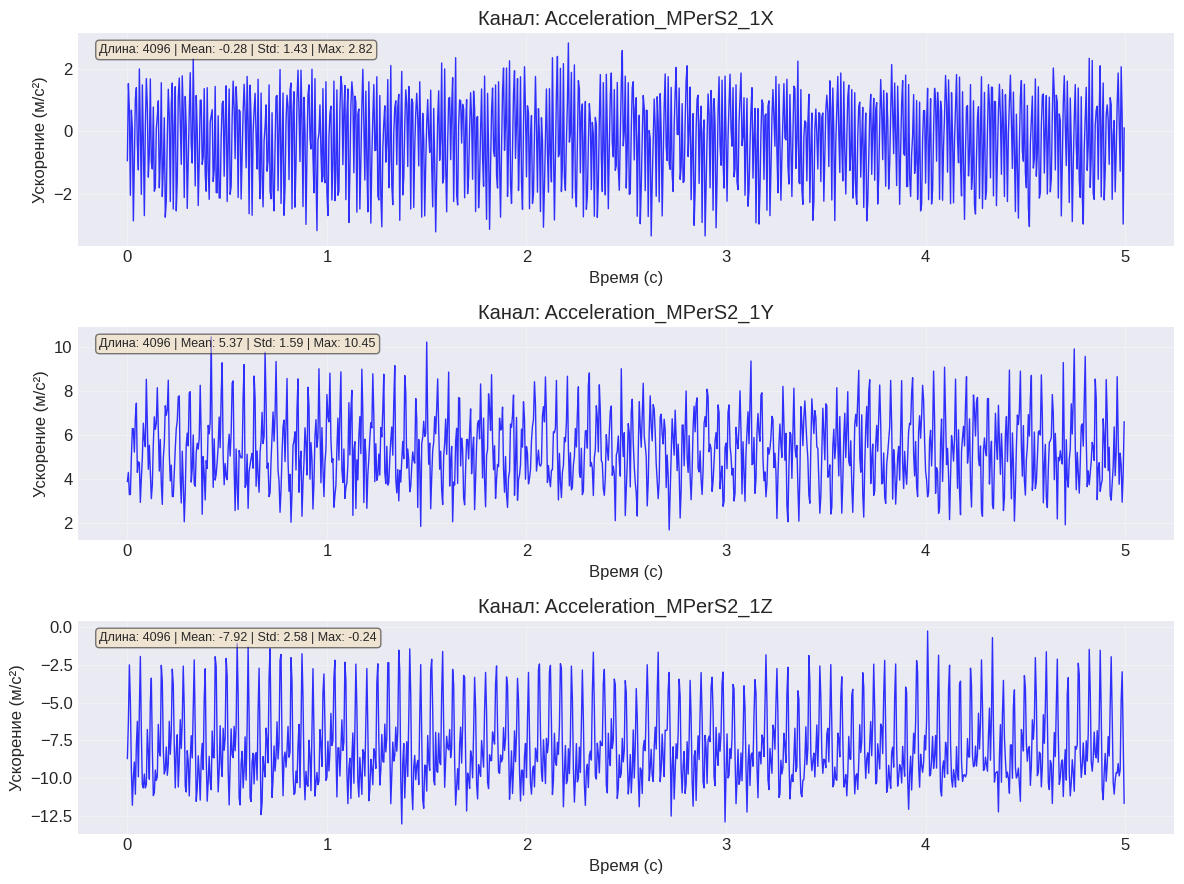

In [21]:
# @title 5. Визуализация исходных сигналов ускорения

# Выбираем каналы для визуализации (можно изменить)
channels_to_plot = channels_to_analyze  # Используем выбранные ранее каналы

print("Визуализация исходных сигналов:")
print("-" * 40)
for channel in channels_to_plot:
    signal_data = df[channel].values
    signal_clean = signal_data[~np.isnan(signal_data)]
    print(f"{channel}: {len(signal_clean)} отсчетов, "
          f"Среднее: {np.mean(signal_clean):.2f}, "
          f"Стд: {np.std(signal_clean):.2f}")

plot_original_signals(df, channels_to_plot, fs=SAMPLING_FREQUENCY, max_samples=1000)

Анализ канала: Acceleration_MPerS2_1X


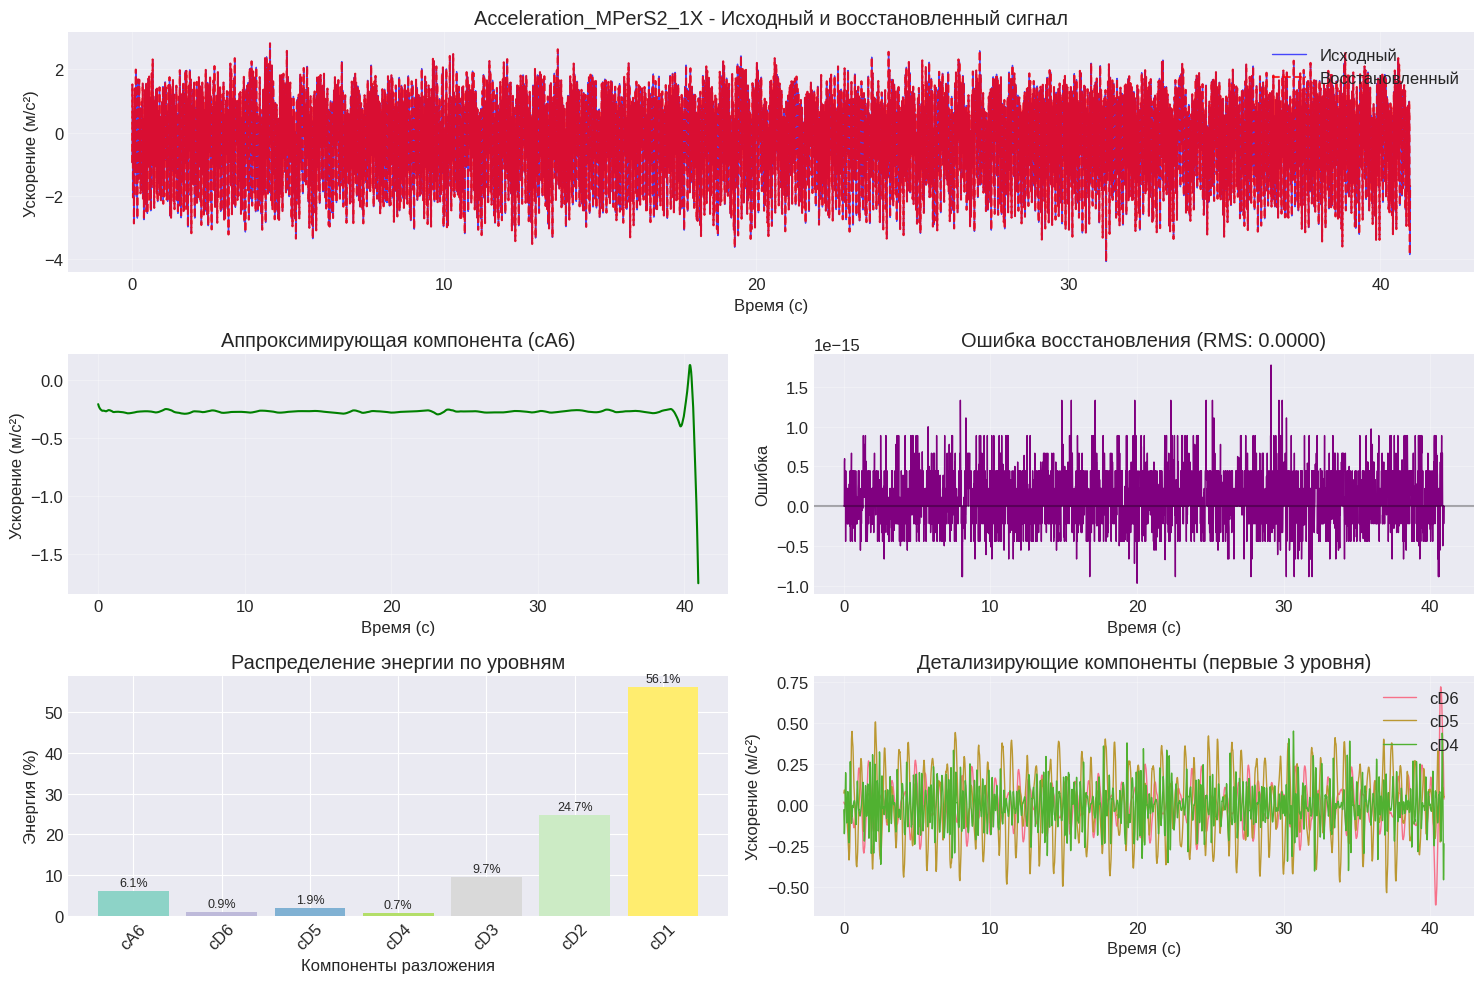


СТАТИСТИКА АНАЛИЗА: Acceleration_MPerS2_1X
Длина сигнала: 4096 отсчетов
Время записи: 40.96 сек
Общая энергия: 8935.09
Уровень разложения: 6

Распределение энергии:
  cA6: 6.09%
  cD6: 0.90%
  cD5: 1.94%
  cD4: 0.66%
  cD3: 9.66%
  cD2: 24.67%
  cD1: 56.07%


In [7]:
# @title 6. DWT анализ выбранного канала

# Выбор канала для анализа
channel_to_analyze = channels_to_analyze[0]  # Первый канал
print(f"Анализ канала: {channel_to_analyze}")

# Получение данных канала
signal_data = df[channel_to_analyze].values

# Выполнение DWT анализа
dwt_results = perform_dwt_analysis(signal_data, WAVELET_NAME, DWT_LEVEL, SAMPLING_FREQUENCY)

# Визуализация результатов
fig = plt.figure(figsize=(15, 10))

# 1. Исходный и восстановленный сигнал
ax1 = plt.subplot(3, 1, 1)
t = np.arange(len(dwt_results['signal_clean'])) / SAMPLING_FREQUENCY
ax1.plot(t, dwt_results['signal_clean'], 'b-', linewidth=1, alpha=0.7, label='Исходный')
ax1.plot(t, dwt_results['reconstructed'], 'r--', linewidth=1.5, alpha=0.8, label='Восстановленный')
ax1.set_xlabel('Время (с)')
ax1.set_ylabel('Ускорение (м/с²)')
ax1.set_title(f'{channel_to_analyze} - Исходный и восстановленный сигнал')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. Аппроксимирующая компонента (низкие частоты)
ax2 = plt.subplot(3, 2, 3)
ax2.plot(t, dwt_results['components']['approximation'], 'g-', linewidth=1.5)
ax2.set_xlabel('Время (с)')
ax2.set_ylabel('Ускорение (м/с²)')
ax2.set_title(f'Аппроксимирующая компонента (cA{DWT_LEVEL})')
ax2.grid(True, alpha=0.3)

# 3. Ошибка восстановления
ax3 = plt.subplot(3, 2, 4)
error = dwt_results['signal_clean'] - dwt_results['reconstructed']
ax3.plot(t, error, 'purple', linewidth=1)
ax3.set_xlabel('Время (с)')
ax3.set_ylabel('Ошибка')
ax3.set_title(f'Ошибка восстановления (RMS: {np.sqrt(np.mean(error**2)):.4f})')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='k', linestyle='-', alpha=0.3)

# 4. Распределение энергии
ax4 = plt.subplot(3, 2, 5)
energy_levels, percentages, total_energy = calculate_energy_distribution(dwt_results['coeffs'])
levels = [f'cA{DWT_LEVEL}'] + [f'cD{DWT_LEVEL-i}' for i in range(DWT_LEVEL)]
colors = plt.cm.Set3(np.linspace(0, 1, len(levels)))
bars = ax4.bar(levels, percentages, color=colors)
ax4.set_xlabel('Компоненты разложения')
ax4.set_ylabel('Энергия (%)')
ax4.set_title('Распределение энергии по уровням')
ax4.tick_params(axis='x', rotation=45)

# Добавление значений на столбцы
for bar, percentage in zip(bars, percentages):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

# 5. Детализирующие компоненты (первые 3 уровня)
ax5 = plt.subplot(3, 2, 6)
for i, detail in enumerate(dwt_results['components']['details'][:3]):
    ax5.plot(t, detail, linewidth=1, label=f'cD{DWT_LEVEL-i}')
ax5.set_xlabel('Время (с)')
ax5.set_ylabel('Ускорение (м/с²)')
ax5.set_title('Детализирующие компоненты (первые 3 уровня)')
ax5.legend(loc='upper right')
ax5.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод статистики
print("\n" + "="*50)
print(f"СТАТИСТИКА АНАЛИЗА: {channel_to_analyze}")
print("="*50)
print(f"Длина сигнала: {len(dwt_results['signal_clean'])} отсчетов")
print(f"Время записи: {len(dwt_results['signal_clean'])/SAMPLING_FREQUENCY:.2f} сек")
print(f"Общая энергия: {total_energy:.2f}")
print(f"Уровень разложения: {DWT_LEVEL}")
print("\nРаспределение энергии:")
for level, percentage in zip(levels, percentages):
    print(f"  {level}: {percentage:.2f}%")

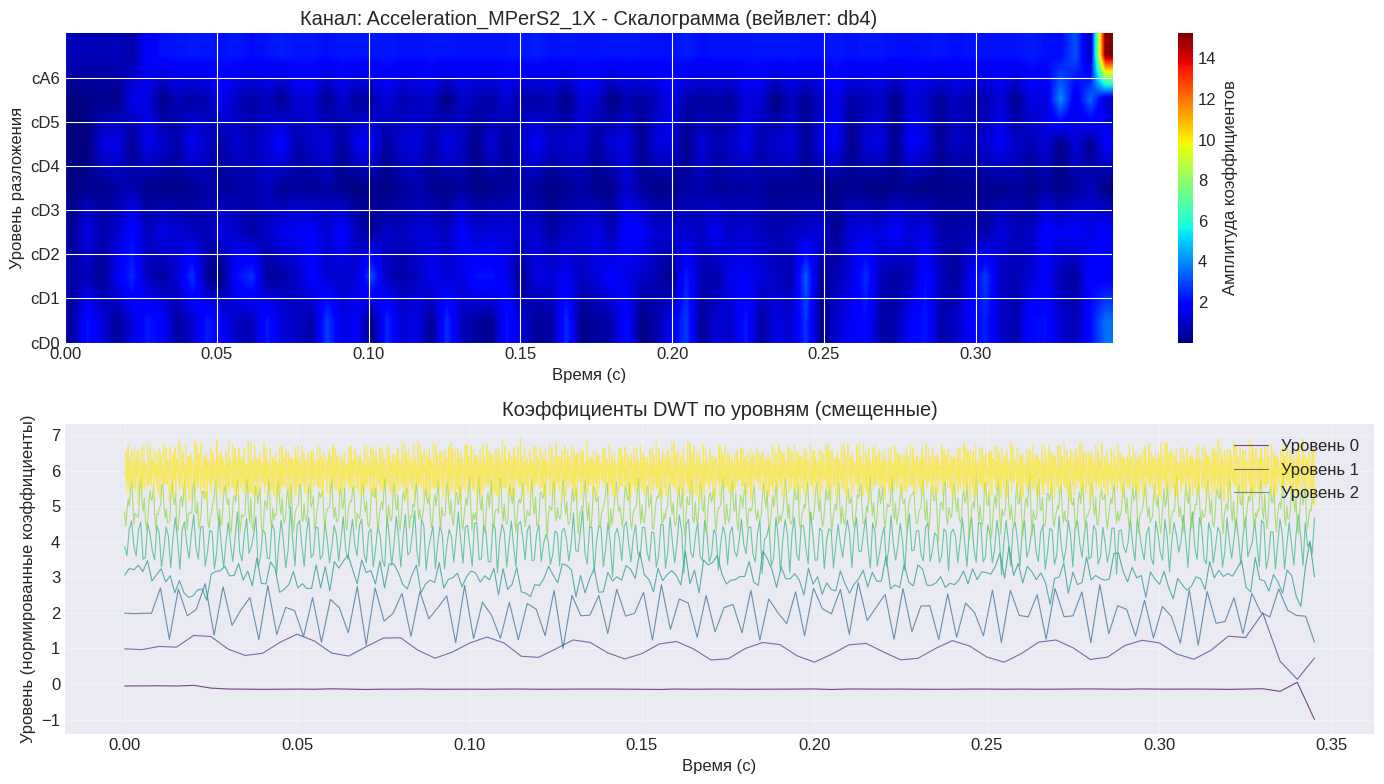

In [23]:
# @title 7. Построение скалограммы (вейвлет-спектрограммы)

def plot_scalogram(coeffs, fs=200.0, title="", wavelet_name=""):
    """
    Построение скалограммы (вейвлет-спектрограммы)
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # 1. Скалограмма (heatmap)
    # Подготовка данных
    max_len = len(coeffs[0])
    scalogram_data = []

    for i, coeff in enumerate(coeffs):
        # Интерполируем коэффициенты до одинаковой длины
        coeff_interp = np.interp(np.linspace(0, len(coeff)-1, max_len),
                                np.arange(len(coeff)), np.abs(coeff))
        scalogram_data.append(coeff_interp)

    scalogram_data = np.array(scalogram_data)

    # Время
    t = np.arange(max_len) / fs if fs > 0 else np.arange(max_len)

    # Построение heatmap
    im = ax1.imshow(scalogram_data, aspect='auto', cmap='jet',
                   extent=[t[0], t[-1], len(coeffs), 0],
                   interpolation='bilinear')

    ax1.set_xlabel('Время (с)')
    ax1.set_ylabel('Уровень разложения')
    ax1.set_title(f'{title} - Скалограмма (вейвлет: {wavelet_name})')
    ax1.set_yticks(range(1, len(coeffs) + 1))
    ax1.set_yticklabels([f'cA{len(coeffs)-1}'] +
                       [f'cD{len(coeffs)-1-i}' for i in range(1, len(coeffs))])

    plt.colorbar(im, ax=ax1, label='Амплитуда коэффициентов')

    # 2. График коэффициентов по уровням
    colors = plt.cm.viridis(np.linspace(0, 1, len(coeffs)))

    for i, coeff in enumerate(coeffs):
        coeff_normalized = coeff / np.max(np.abs(coeff)) if np.max(np.abs(coeff)) > 0 else coeff
        t_coeff = np.linspace(t[0], t[-1], len(coeff))
        ax2.plot(t_coeff, coeff_normalized + i,
                color=colors[i], linewidth=0.8, alpha=0.7,
                label=f'Уровень {i}' if i < 3 else "")

    ax2.set_xlabel('Время (с)')
    ax2.set_ylabel('Уровень (нормированные коэффициенты)')
    ax2.set_title('Коэффициенты DWT по уровням (смещенные)')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Построение скалограммы для текущего канала
plot_scalogram(dwt_results['coeffs'],
               fs=SAMPLING_FREQUENCY,
               title=f"Канал: {channel_to_analyze}",
               wavelet_name=WAVELET_NAME)

In [24]:
# @title 8. Анализ всех каналов ускорения

def analyze_all_channels(df, channels, wavelet_name='db4', level=6, fs=100.0):
    """
    Анализ всех указанных каналов
    """
    results = {}

    for channel in channels:
        print(f"\n{'='*60}")
        print(f"АНАЛИЗ КАНАЛА: {channel}")
        print(f"{'='*60}")

        # Получение данных
        signal_data = df[channel].values

        # DWT анализ
        dwt_result = perform_dwt_analysis(signal_data, wavelet_name, level, fs)

        # Расчет энергии
        _, percentages, total_energy = calculate_energy_distribution(dwt_result['coeffs'])

        # Сохранение результатов
        results[channel] = {
            'dwt': dwt_result,
            'energy_percentages': percentages,
            'total_energy': total_energy,
            'rms_error': np.sqrt(np.mean((dwt_result['signal_clean'] - dwt_result['reconstructed'])**2))
        }

        # Краткая статистика
        print(f"Длина сигнала: {len(dwt_result['signal_clean'])}")
        print(f"Общая энергия: {total_energy:.2f}")
        print(f"Ошибка восстановления (RMS): {results[channel]['rms_error']:.4f}")
        print("Распределение энергии (первые 3 уровня):")
        for i, pct in enumerate(percentages[:3]):
            level_name = f'cA{level}' if i == 0 else f'cD{level+1-i}'
            print(f"  {level_name}: {pct:.1f}%")

    return results

# Анализ всех выбранных каналов
print("НАЧИНАЕМ АНАЛИЗ ВСЕХ КАНАЛОВ...")
all_results = analyze_all_channels(df, channels_to_analyze,
                                   WAVELET_NAME, DWT_LEVEL, SAMPLING_FREQUENCY)

НАЧИНАЕМ АНАЛИЗ ВСЕХ КАНАЛОВ...

АНАЛИЗ КАНАЛА: Acceleration_MPerS2_1X
Длина сигнала: 4096
Общая энергия: 8738.59
Ошибка восстановления (RMS): 0.0000
Распределение энергии (первые 3 уровня):
  cA4: 6.9%
  cD4: 0.7%
  cD3: 9.9%

АНАЛИЗ КАНАЛА: Acceleration_MPerS2_1Y
Длина сигнала: 4096
Общая энергия: 130743.95
Ошибка восстановления (RMS): 0.0000
Распределение энергии (первые 3 уровня):
  cA4: 92.3%
  cD4: 0.1%
  cD3: 3.8%

АНАЛИЗ КАНАЛА: Acceleration_MPerS2_1Z
Длина сигнала: 4096
Общая энергия: 289681.60
Ошибка восстановления (RMS): 0.0000
Распределение энергии (первые 3 уровня):
  cA4: 90.8%
  cD4: 0.1%
  cD3: 3.6%


Оптимизация параметров для канала: Acceleration_MPerS2_1X
Длина сигнала: 4096 отсчетов

ПОДБОР ПАРАМЕТРОВ ДЛЯ КАНАЛА: Acceleration_MPerS2_1X

Тест 1: Вейвлет=db4, Уровень=5, Цветовая карта=jet


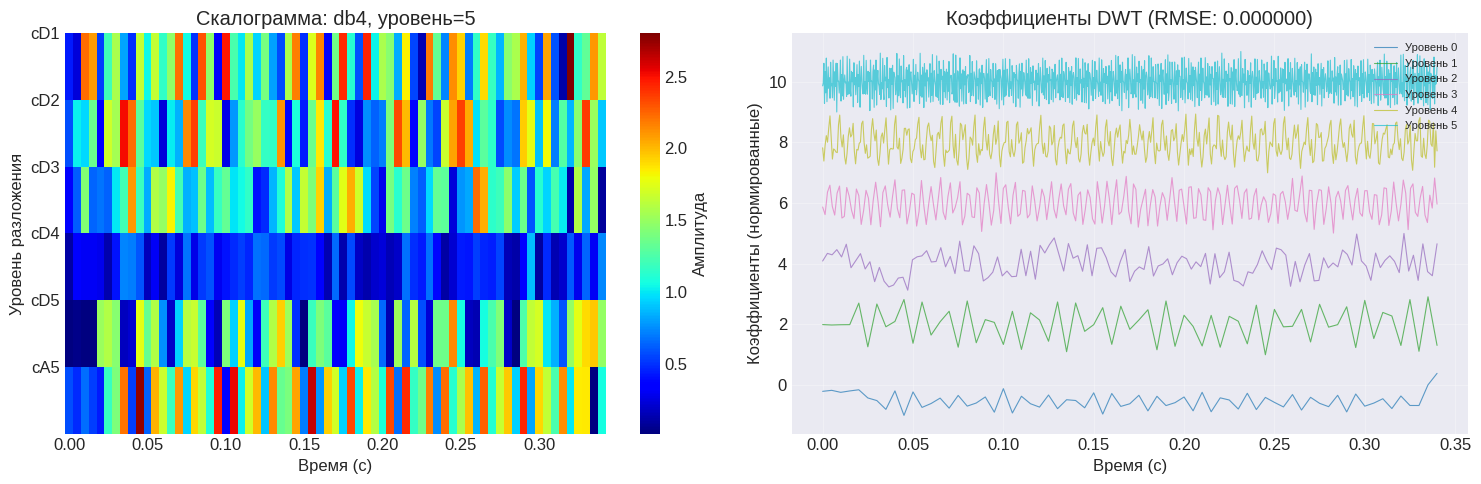

  ✓ RMSE: 0.000000
  ✓ Распределение энергии: cA5:4.1%, cD1:57.4%

Тест 2: Вейвлет=sym8, Уровень=6, Цветовая карта=viridis


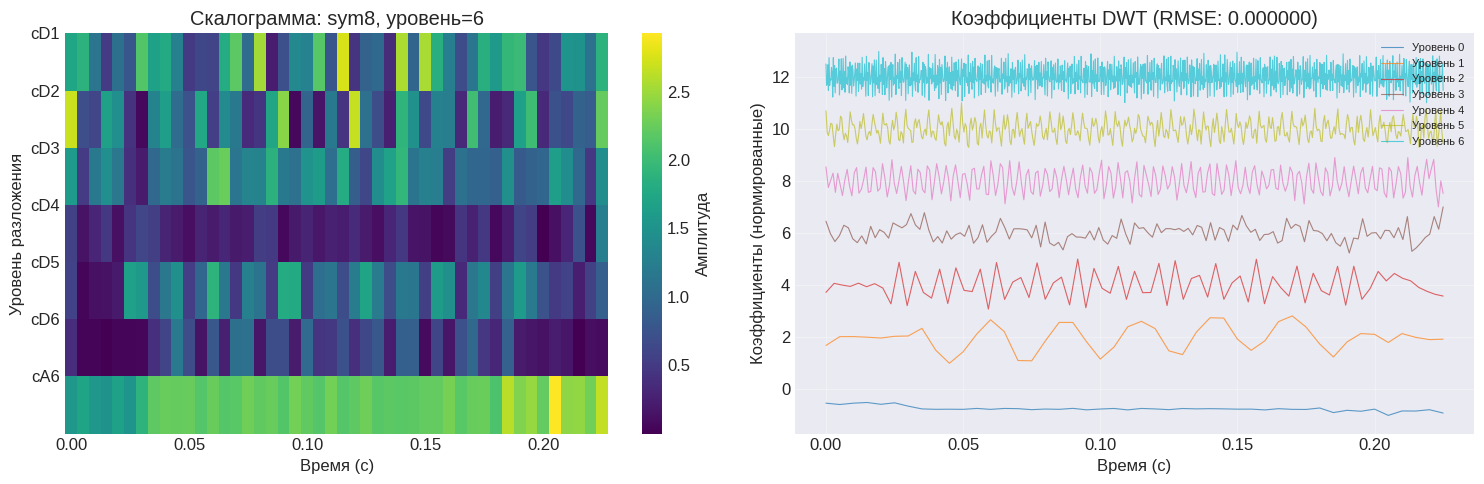

  ✓ RMSE: 0.000000
  ✓ Распределение энергии: cA6:5.0%, cD1:59.3%

Тест 3: Вейвлет=coif4, Уровень=5, Цветовая карта=plasma


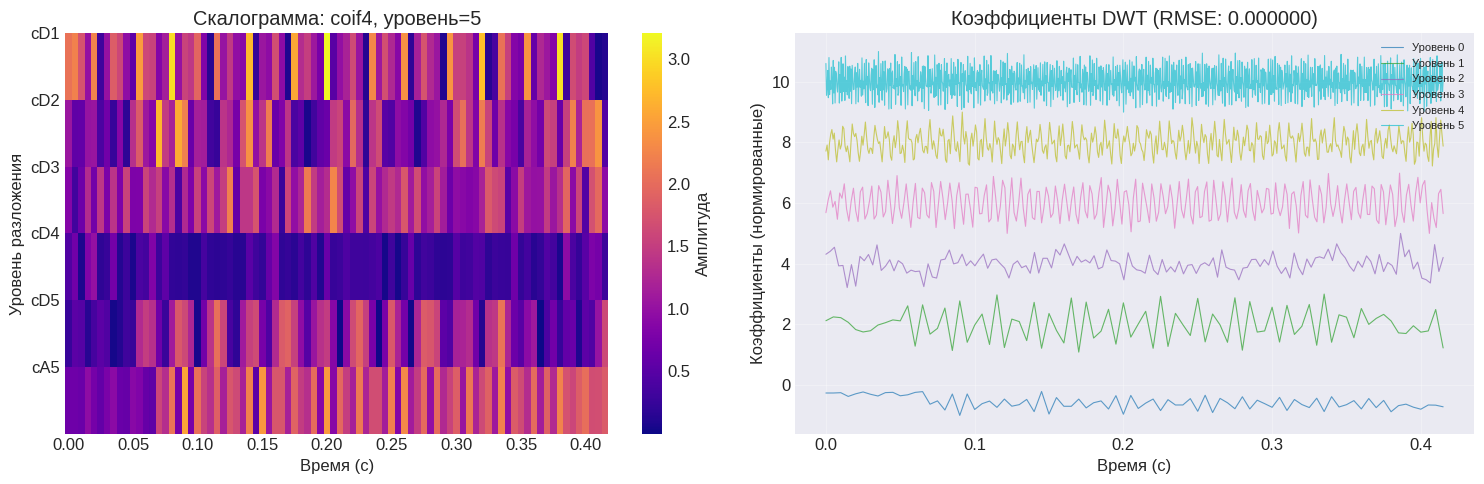

  ✓ RMSE: 0.000000
  ✓ Распределение энергии: cA5:4.5%, cD1:59.9%

Тест 4: Вейвлет=bior3.3, Уровень=5, Цветовая карта=hot


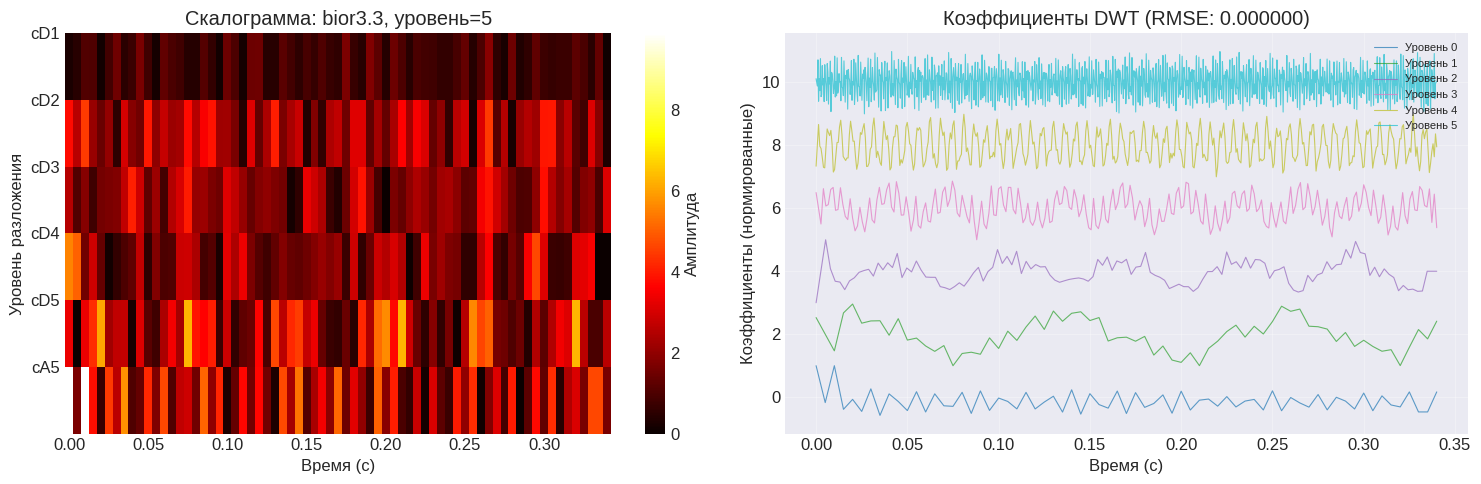

  ✓ RMSE: 0.000000
  ✓ Распределение энергии: cA5:9.7%, cD1:13.1%

Тест 5: Вейвлет=db8, Уровень=4, Цветовая карта=coolwarm


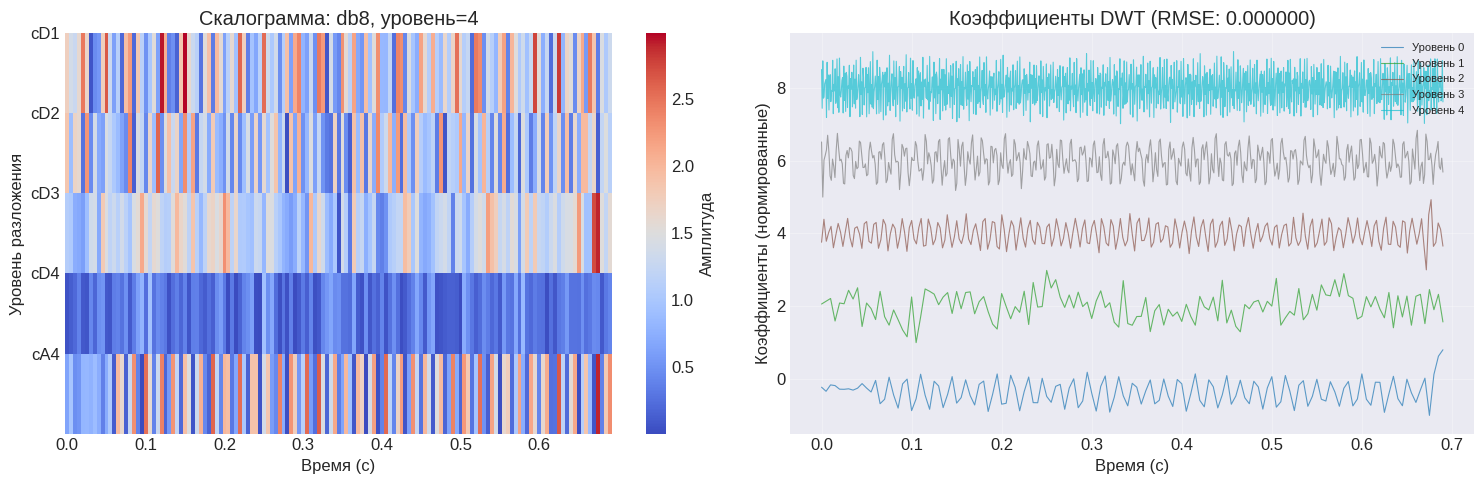

  ✓ RMSE: 0.000000
  ✓ Распределение энергии: cA4:6.4%, cD1:59.6%

СРАВНЕНИЕ РЕЗУЛЬТАТОВ:

Вейвлет    RMSE         Уровень  cA%      Цвет. карта 
------------------------------------------------------------
db4        0.000000     5        4.1      jet         
bior3.3    0.000000     5        9.7      hot         
db8        0.000000     4        6.4      coolwarm    
coif4      0.000000     5        4.5      plasma      
sym8       0.000000     6        5.0      viridis     

✨ Рекомендуемый вейвлет: db4
   Лучшая ошибка восстановления: 0.000000

СОЗДАНИЕ УЛУЧШЕННОЙ СКАЛОГРАММЫ С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ
Ошибка при создании скалограммы: x and y must have same first dimension, but have shapes (134,) and (4096,)

Протестировать на других каналах? (y/n): y

Тестирование канала: Acceleration_MPerS2_1Y
Ошибка при создании скалограммы: x and y must have same first dimension, but have shapes (134,) and (4096,)

Тестирование канала: Acceleration_MPerS2_1Z
Ошибка при создании скалограммы: x a

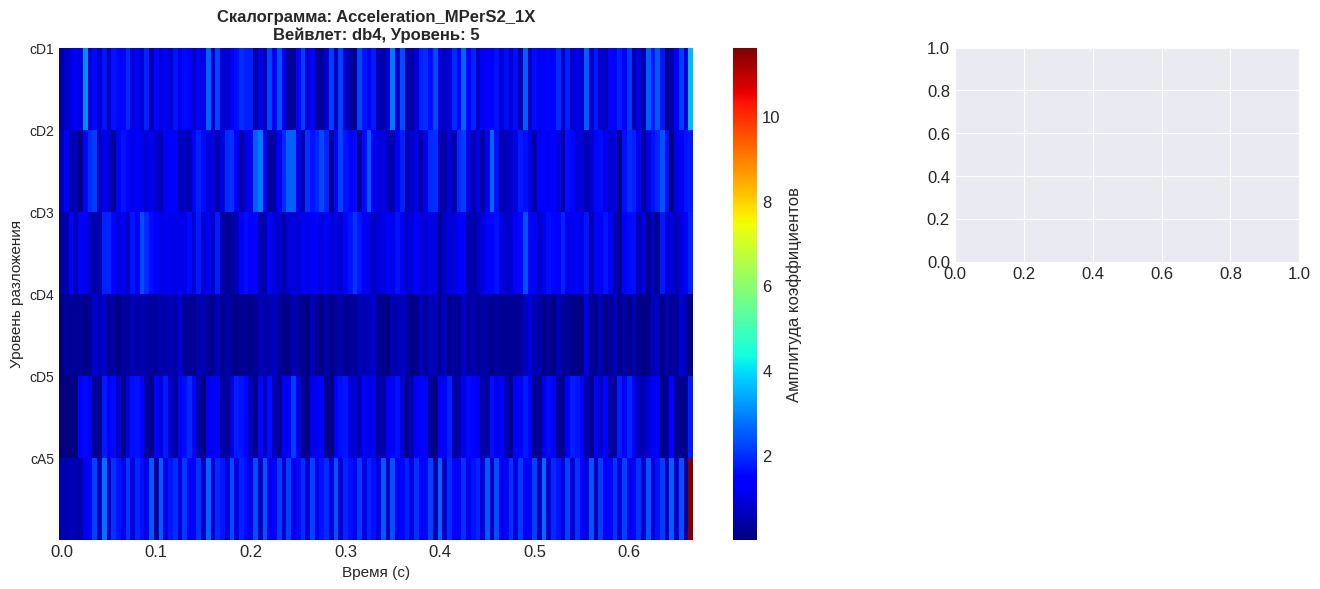

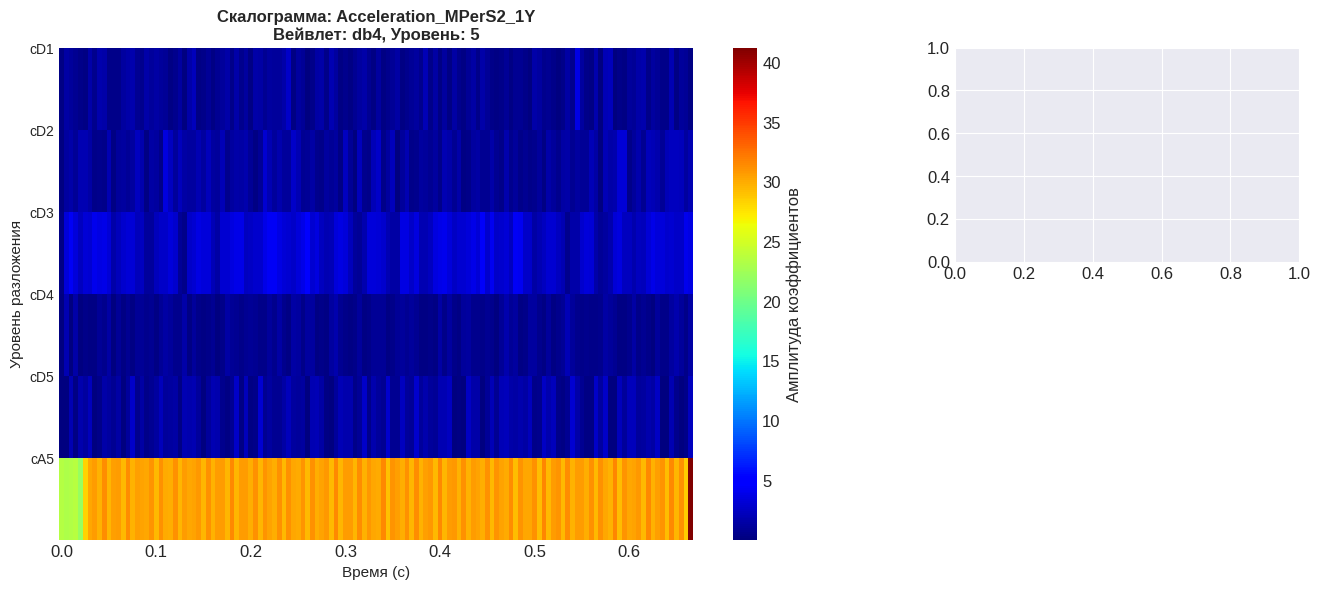

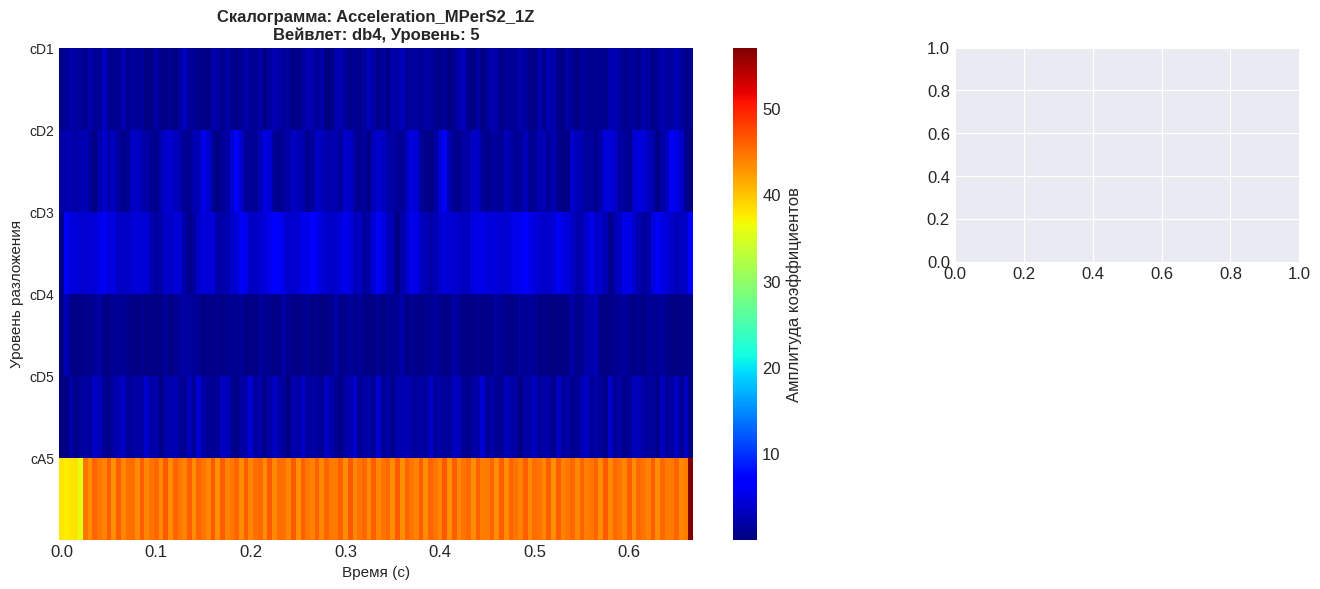

In [30]:
# @title 9. Настройка параметров визуализации и подбор вейвлетов

def optimize_scalogram_parameters(signal_data, channel_name, fs=SAMPLING_FREQUENCY):
    """
    Подбор оптимальных параметров для визуализации скалограммы
    """
    print(f"\n{'='*60}")
    print(f"ПОДБОР ПАРАМЕТРОВ ДЛЯ КАНАЛА: {channel_name}")
    print(f"{'='*60}")

    # Различные варианты параметров для тестирования
    test_params = [
        {'wavelet': 'db4', 'level': 5, 'cmap': 'jet'},
        {'wavelet': 'sym8', 'level': 6, 'cmap': 'viridis'},
        {'wavelet': 'coif4', 'level': 5, 'cmap': 'plasma'},
        {'wavelet': 'bior3.3', 'level': 5, 'cmap': 'hot'},
        {'wavelet': 'db8', 'level': 4, 'cmap': 'coolwarm'},
    ]

    results = {}

    for i, params in enumerate(test_params):
        wavelet = params['wavelet']
        level = params['level']
        cmap = params['cmap']

        print(f"\nТест {i+1}: Вейвлет={wavelet}, Уровень={level}, Цветовая карта={cmap}")

        try:
            # Проверяем длину сигнала
            if len(signal_data) < 2**level:
                print(f"  ⚠ Длина сигнала ({len(signal_data)}) < 2^{level}")
                level_adjusted = min(level, int(np.log2(len(signal_data))) - 1)
                print(f"  Используем уровень: {level_adjusted}")
                level = level_adjusted

            # Выполняем DWT
            coeffs = pywt.wavedec(signal_data, wavelet, level=level)

            # Восстанавливаем сигнал
            reconstructed = pywt.waverec(coeffs, wavelet)

            # Вычисляем ошибку
            error = signal_data - reconstructed
            rmse = np.sqrt(np.mean(error**2))

            # Вычисляем распределение энергии
            total_energy = sum([np.sum(c**2) for c in coeffs])
            energy_percentages = []
            for c in coeffs:
                energy_percentages.append(np.sum(c**2) / total_energy * 100)

            # Визуализация
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

            # 1. Скалограмма
            max_len = len(coeffs[0])
            scalogram_data = []

            for coeff in coeffs:
                coeff_interp = np.interp(np.linspace(0, len(coeff)-1, max_len),
                                        np.arange(len(coeff)), np.abs(coeff))
                scalogram_data.append(coeff_interp)

            scalogram_data = np.array(scalogram_data)
            t = np.arange(max_len) / fs

            # Используем pcolormesh вместо imshow для большей стабильности
            X, Y = np.meshgrid(t, np.arange(len(coeffs)))
            mesh = ax1.pcolormesh(X, Y, scalogram_data, cmap=cmap, shading='auto')

            ax1.set_xlabel('Время (с)')
            ax1.set_ylabel('Уровень разложения')
            ax1.set_title(f'Скалограмма: {wavelet}, уровень={level}')
            ax1.set_yticks(np.arange(len(coeffs)) + 0.5)
            ax1.set_yticklabels([f'cA{level}'] + [f'cD{level-i}' for i in range(level)])

            plt.colorbar(mesh, ax=ax1, label='Амплитуда')

            # 2. График коэффициентов
            colors = plt.cm.tab10(np.linspace(0, 1, len(coeffs)))

            for idx, coeff in enumerate(coeffs):
                coeff_normalized = coeff / np.max(np.abs(coeff)) if np.max(np.abs(coeff)) > 0 else coeff
                t_coeff = np.linspace(t[0], t[-1], len(coeff))
                ax2.plot(t_coeff, coeff_normalized + idx * 2,
                        color=colors[idx], linewidth=0.8, alpha=0.7,
                        label=f'Уровень {idx}')

            ax2.set_xlabel('Время (с)')
            ax2.set_ylabel('Коэффициенты (нормированные)')
            ax2.set_title(f'Коэффициенты DWT (RMSE: {rmse:.6f})')
            ax2.grid(True, alpha=0.3)
            ax2.legend(loc='upper right', fontsize=8)

            plt.tight_layout()
            plt.show()

            # Сохраняем результаты
            results[wavelet] = {
                'rmse': rmse,
                'level': level,
                'energy_distribution': energy_percentages,
                'total_energy': total_energy,
                'cmap': cmap
            }

            print(f"  ✓ RMSE: {rmse:.6f}")
            print(f"  ✓ Распределение энергии: cA{level}:{energy_percentages[0]:.1f}%, "
                  f"cD1:{energy_percentages[-1]:.1f}%")

        except Exception as e:
            print(f"  ✗ Ошибка: {e}")
            results[wavelet] = {'rmse': np.inf, 'error': str(e)}

    # Сравнение результатов
    print(f"\n{'='*60}")
    print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ:")
    print(f"{'='*60}")

    valid_results = {k: v for k, v in results.items() if 'rmse' in v and v['rmse'] < np.inf}

    if valid_results:
        print(f"\n{'Вейвлет':<10} {'RMSE':<12} {'Уровень':<8} {'cA%':<8} {'Цвет. карта':<12}")
        print("-" * 60)

        for wavelet, res in sorted(valid_results.items(), key=lambda x: x[1]['rmse']):
            print(f"{wavelet:<10} {res['rmse']:<12.6f} {res.get('level', 'N/A'):<8} "
                  f"{res.get('energy_distribution', [0])[0]:<8.1f} "
                  f"{res.get('cmap', 'N/A'):<12}")

        # Рекомендация
        best_wavelet = min(valid_results.items(), key=lambda x: x[1]['rmse'])[0]
        print(f"\n✨ Рекомендуемый вейвлет: {best_wavelet}")
        print(f"   Лучшая ошибка восстановления: {valid_results[best_wavelet]['rmse']:.6f}")

        return best_wavelet, valid_results[best_wavelet]
    else:
        print("Не удалось получить результаты для сравнения")
        return None, None

def create_enhanced_scalogram(signal_data, wavelet_name, level, fs=SAMPLING_FREQUENCY,
                             channel_name="", cmap='viridis'):
    """
    Создание улучшенной скалограммы с дополнительной информацией
    """
    try:
        # Выполняем DWT
        coeffs = pywt.wavedec(signal_data, wavelet_name, level=level)

        # Создаем фигуру
        fig = plt.figure(figsize=(16, 10))

        # 1. Основная скалограмма (занимает больше места)
        gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

        ax1 = fig.add_subplot(gs[0:2, 0:2])  # Скалограмма

        # Подготовка данных для скалограммы
        max_len = len(coeffs[0])
        scalogram_data = []

        for coeff in coeffs:
            coeff_interp = np.interp(np.linspace(0, len(coeff)-1, max_len),
                                    np.arange(len(coeff)), np.abs(coeff))
            scalogram_data.append(coeff_interp)

        scalogram_data = np.array(scalogram_data)
        t = np.arange(max_len) / fs

        # Используем pcolormesh для стабильности
        X, Y = np.meshgrid(t, np.arange(len(coeffs)))
        mesh = ax1.pcolormesh(X, Y, scalogram_data, cmap=cmap, shading='auto')

        ax1.set_xlabel('Время (с)', fontsize=11)
        ax1.set_ylabel('Уровень разложения', fontsize=11)
        ax1.set_title(f'Скалограмма: {channel_name}\nВейвлет: {wavelet_name}, Уровень: {level}',
                     fontsize=12, fontweight='bold')
        ax1.set_yticks(np.arange(len(coeffs)) + 0.5)
        ax1.set_yticklabels([f'cA{level}'] + [f'cD{level-i}' for i in range(level)], fontsize=10)

        plt.colorbar(mesh, ax=ax1, label='Амплитуда коэффициентов')

        # 2. График исходного сигнала
        ax2 = fig.add_subplot(gs[0, 2])
        ax2.plot(t, signal_data, 'b-', linewidth=1, alpha=0.7)
        ax2.set_xlabel('Время (с)', fontsize=10)
        ax2.set_ylabel('Амплитуда', fontsize=10)
        ax2.set_title('Исходный сигнал', fontsize=11)
        ax2.grid(True, alpha=0.3)

        # 3. Распределение энергии
        ax3 = fig.add_subplot(gs[1, 2])
        total_energy = sum([np.sum(c**2) for c in coeffs])
        energy_percentages = [np.sum(c**2) / total_energy * 100 for c in coeffs]

        levels = [f'cA{level}'] + [f'cD{level-i}' for i in range(level)]
        colors = plt.cm.Set3(np.linspace(0, 1, len(levels)))

        bars = ax3.bar(levels, energy_percentages, color=colors, edgecolor='black')
        ax3.set_xlabel('Компоненты', fontsize=10)
        ax3.set_ylabel('Энергия (%)', fontsize=10)
        ax3.set_title('Распределение энергии', fontsize=11)
        ax3.tick_params(axis='x', rotation=45)
        ax3.grid(True, alpha=0.3, axis='y')

        # Добавляем значения на столбцы
        for bar, percentage in zip(bars, energy_percentages):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)

        # 4. Аппроксимирующая компонента
        ax4 = fig.add_subplot(gs[2, 0])
        ax4.plot(t, coeffs[0], 'g-', linewidth=1)
        ax4.set_xlabel('Время (с)', fontsize=10)
        ax4.set_ylabel('Амплитуда', fontsize=10)
        ax4.set_title(f'Аппроксимирующие коэффициенты (cA{level})', fontsize=11)
        ax4.grid(True, alpha=0.3)

        # 5. Детализирующие коэффициенты (первые 3 уровня)
        ax5 = fig.add_subplot(gs[2, 1])
        colors_detail = ['red', 'blue', 'orange', 'purple']
        for i in range(min(3, len(coeffs)-1)):
            ax5.plot(np.linspace(t[0], t[-1], len(coeffs[i+1])),
                    coeffs[i+1],
                    color=colors_detail[i % len(colors_detail)],
                    linewidth=0.8, alpha=0.7,
                    label=f'cD{level-i}')

        ax5.set_xlabel('Время (с)', fontsize=10)
        ax5.set_ylabel('Амплитуда', fontsize=10)
        ax5.set_title('Детализирующие коэффициенты', fontsize=11)
        ax5.legend(loc='upper right', fontsize=9)
        ax5.grid(True, alpha=0.3)

        # 6. Информационная панель
        ax6 = fig.add_subplot(gs[2, 2])
        ax6.axis('off')

        # Восстановленный сигнал для расчета ошибки
        reconstructed = pywt.waverec(coeffs, wavelet_name)
        rmse = np.sqrt(np.mean((signal_data - reconstructed)**2))

        # Текстовая информация
        info_text = f"""
ИНФОРМАЦИЯ О РАЗЛОЖЕНИИ:

Канал: {channel_name}
Вейвлет: {wavelet_name}
Уровень разложения: {level}
Длина сигнала: {len(signal_data)} отсч.
Длительность: {len(signal_data)/fs:.2f} сек

СТАТИСТИКА:

RMSE восстановления: {rmse:.6f}
Общая энергия: {total_energy:.2f}
Доля в cA{level}: {energy_percentages[0]:.1f}%
Доля в cD1: {energy_percentages[-1]:.1f}%

ВИЗУАЛИЗАЦИЯ:

Цветовая карта: {cmap}
"""

        ax6.text(0.05, 0.95, info_text, transform=ax6.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.show()

        return {
            'coeffs': coeffs,
            'rmse': rmse,
            'energy_percentages': energy_percentages,
            'total_energy': total_energy
        }

    except Exception as e:
        print(f"Ошибка при создании скалограммы: {e}")
        return None

# Основной блок выполнения
if 'all_results' in locals() and all_results and channels_to_analyze:
    # Берем первый канал для оптимизации
    first_channel = channels_to_analyze[0]

    if first_channel in all_results:
        signal_data = all_results[first_channel]['dwt']['signal_clean']

        print(f"Оптимизация параметров для канала: {first_channel}")
        print(f"Длина сигнала: {len(signal_data)} отсчетов")

        # Подбор оптимальных параметров
        best_wavelet, best_params = optimize_scalogram_parameters(
            signal_data[:2000] if len(signal_data) > 2000 else signal_data,
            first_channel,
            fs=SAMPLING_FREQUENCY
        )

        if best_wavelet:
            print(f"\n{'='*60}")
            print(f"СОЗДАНИЕ УЛУЧШЕННОЙ СКАЛОГРАММЫ С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ")
            print(f"{'='*60}")

            # Создаем улучшенную скалограмму с оптимальными параметрами
            enhanced_result = create_enhanced_scalogram(
                signal_data,
                best_wavelet,
                best_params.get('level', DWT_LEVEL),
                fs=SAMPLING_FREQUENCY,
                channel_name=first_channel,
                cmap=best_params.get('cmap', 'viridis')
            )

            if enhanced_result:
                print(f"\nАнализ завершен успешно!")
                print(f"Оптимальные параметры для визуализации:")
                print(f"  - Вейвлет: {best_wavelet}")
                print(f"  - Уровень: {best_params.get('level', DWT_LEVEL)}")
                print(f"  - Цветовая карта: {best_params.get('cmap', 'viridis')}")
                print(f"  - RMSE: {enhanced_result['rmse']:.6f}")

        # Можно также протестировать на других каналах
        user_input = input("\nПротестировать на других каналах? (y/n): ")
        if user_input.lower() == 'y':
            for channel in channels_to_analyze[1:min(3, len(channels_to_analyze))]:
                if channel in all_results:
                    signal_data = all_results[channel]['dwt']['signal_clean']
                    print(f"\nТестирование канала: {channel}")

                    # Простая визуализация с оптимальными параметрами
                    if best_wavelet:
                        simple_result = create_enhanced_scalogram(
                            signal_data,
                            best_wavelet,
                            best_params.get('level', DWT_LEVEL),
                            fs=SAMPLING_FREQUENCY,
                            channel_name=channel,
                            cmap=best_params.get('cmap', 'viridis')
                        )
    else:
        print(f"Канал {first_channel} не найден в результатах")
else:
    print("Нет данных для анализа. Сначала выполните анализ в ячейке 8.")

    # Демонстрация на небольшом участке данных
    if 'df' in locals() and not df.empty and len(channels_to_analyze) > 0:
        demo_channel = channels_to_analyze[0]
        demo_signal = df[demo_channel].dropna().values[:1000]  # Только первые 1000 отсчетов

        if len(demo_signal) > 10:
            print(f"\nДемонстрация на канале {demo_channel} (первые 1000 отсчетов):")
            best_wavelet, best_params = optimize_scalogram_parameters(
                demo_signal,
                demo_channel,
                fs=SAMPLING_FREQUENCY
            )


Сравнение вейвлетов для канала: Acceleration_MPerS2_1X
--------------------------------------------------


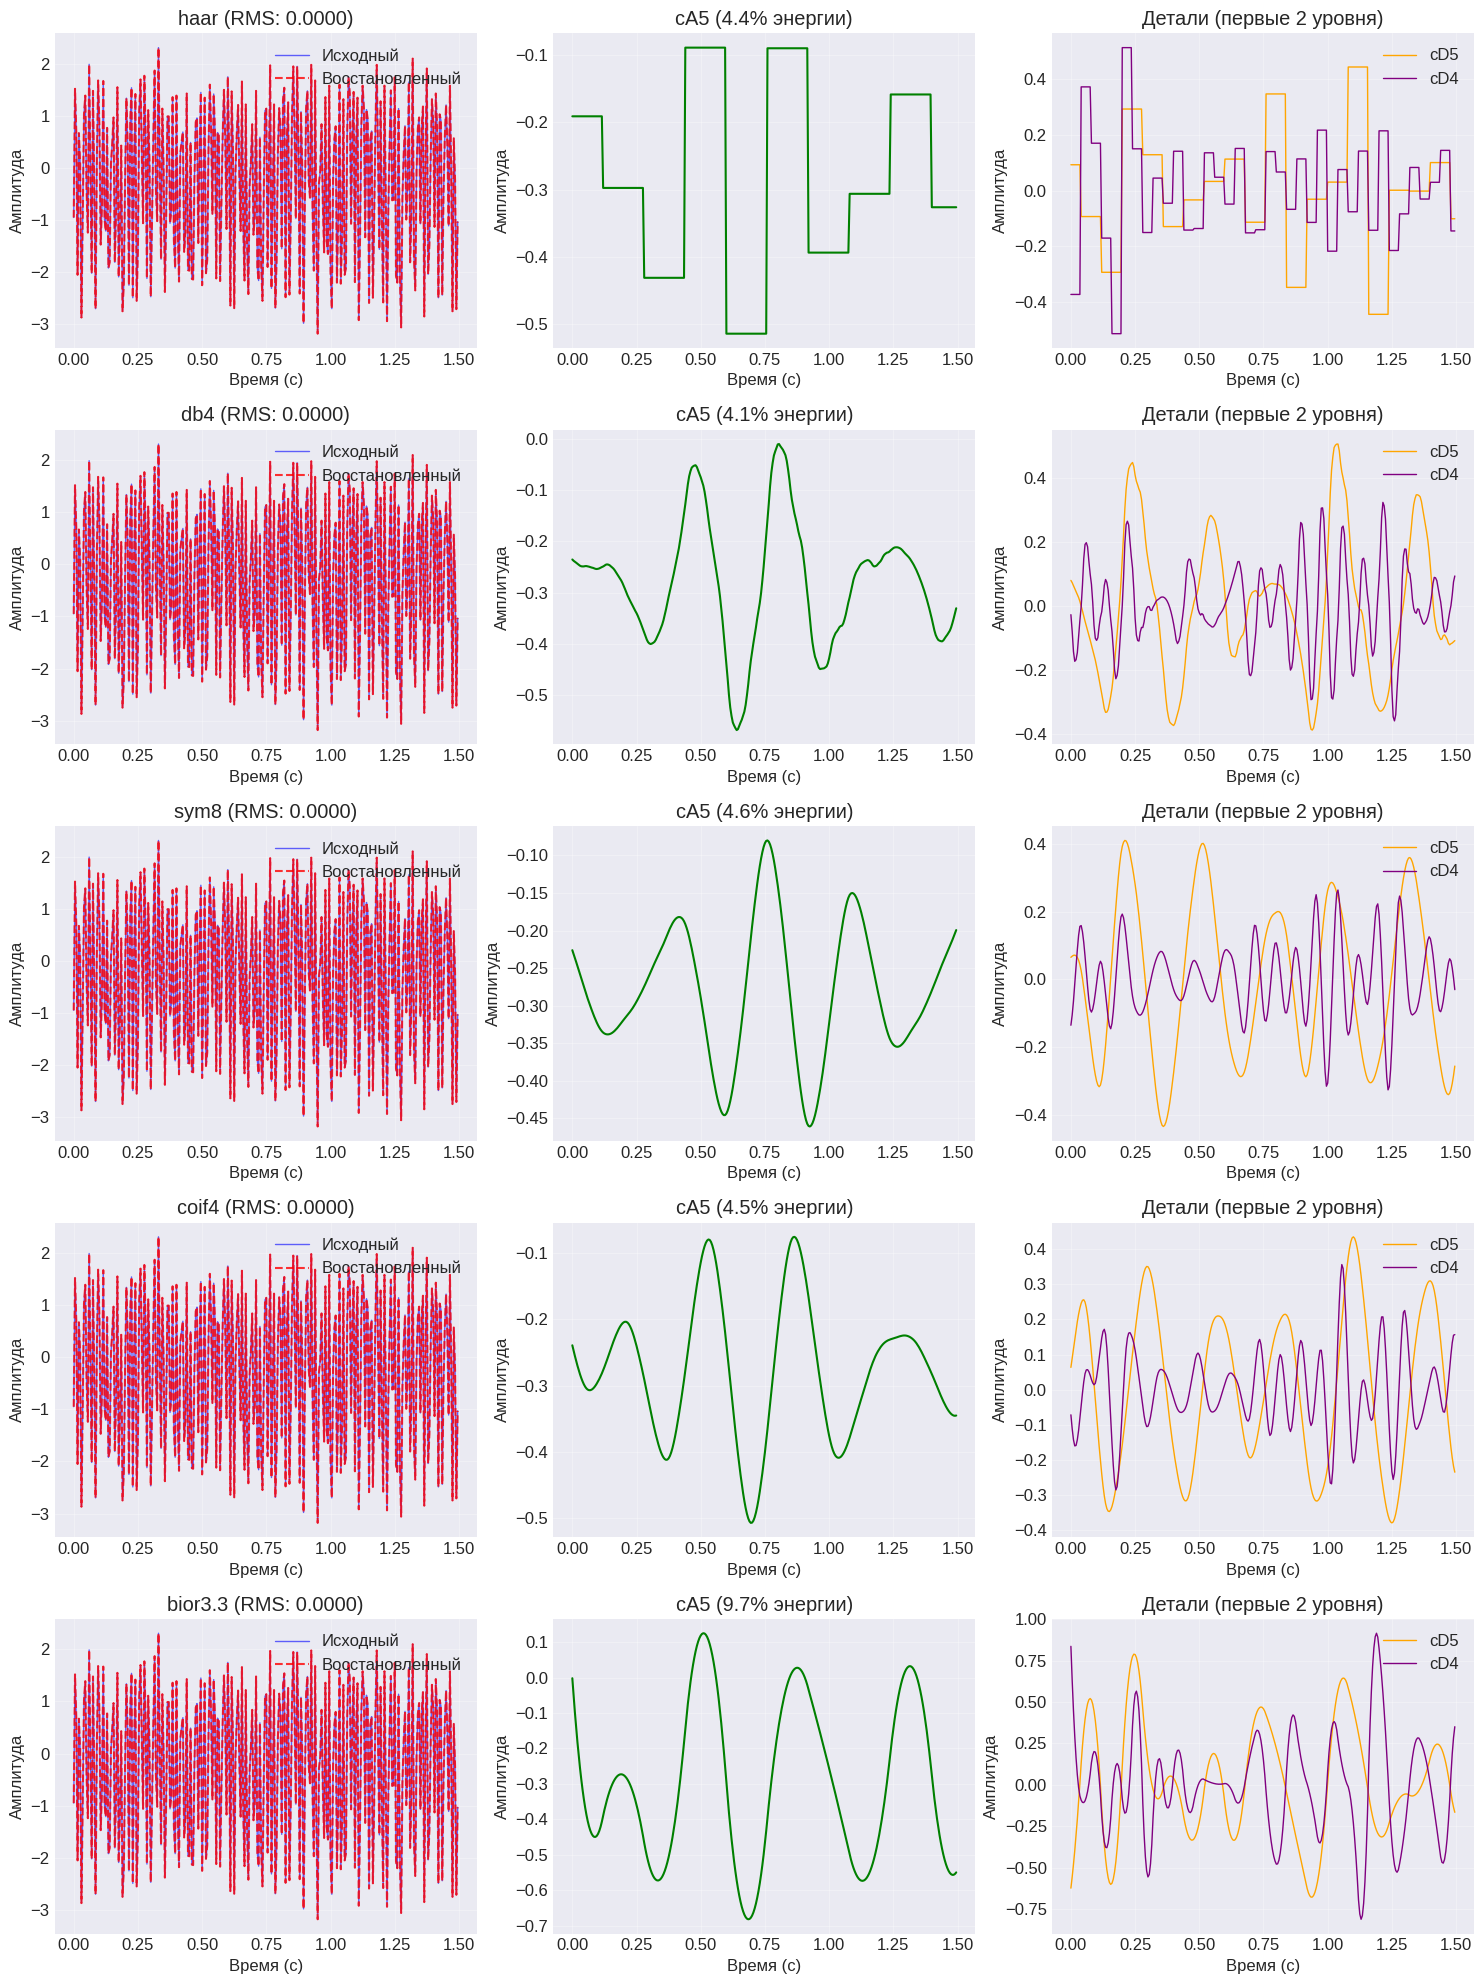


Сравнительная таблица вейвлетов:
--------------------------------------------------


Вейвлет RMS ошибка Энергия cA (%) Общая энергия
0      db4   0.000000            4.1       4290.50
1  bior3.3   0.000000            9.7       7934.29
2    coif4   0.000000            4.5       4399.87
3     haar   0.000000            4.4       4256.17
4     sym8   0.000000            4.6       4370.81

In [27]:
# @title 10. Сравнение разных вейвлетов

def compare_wavelets_for_channel(signal_data, wavelets=['db4', 'sym8', 'coif4', 'bior3.3'],
                                 level=5, fs=100.0, channel_name=""):
    """
    Сравнение разных вейвлетов для одного канала
    """
    print(f"\nСравнение вейвлетов для канала: {channel_name}")
    print("-" * 50)

    results = {}

    fig, axes = plt.subplots(len(wavelets), 3, figsize=(15, 4*len(wavelets)))

    if len(wavelets) == 1:
        axes = axes.reshape(1, -1)

    for idx, wavelet in enumerate(wavelets):
        try:
            # DWT анализ
            dwt_result = perform_dwt_analysis(signal_data, wavelet, level, fs)

            # Расчет ошибки
            error = dwt_result['signal_clean'] - dwt_result['reconstructed']
            rms_error = np.sqrt(np.mean(error**2))

            # Расчет энергии
            _, percentages, total_energy = calculate_energy_distribution(dwt_result['coeffs'])

            # Сохранение результатов
            results[wavelet] = {
                'rms_error': rms_error,
                'total_energy': total_energy,
                'approximation_energy': percentages[0]
            }

            # Графики
            t = np.arange(len(dwt_result['signal_clean'])) / fs

            # 1. Исходный и восстановленный сигнал
            ax1 = axes[idx, 0]
            ax1.plot(t[:300], dwt_result['signal_clean'][:300], 'b-',
                    alpha=0.6, linewidth=1, label='Исходный')
            ax1.plot(t[:300], dwt_result['reconstructed'][:300], 'r--',
                    alpha=0.8, linewidth=1.5, label='Восстановленный')
            ax1.set_xlabel('Время (с)')
            ax1.set_ylabel('Амплитуда')
            ax1.set_title(f'{wavelet} (RMS: {rms_error:.4f})')
            ax1.legend(loc='upper right')
            ax1.grid(True, alpha=0.3)

            # 2. Аппроксимирующая компонента
            ax2 = axes[idx, 1]
            ax2.plot(t[:300], dwt_result['components']['approximation'][:300],
                    'g-', linewidth=1.5)
            ax2.set_xlabel('Время (с)')
            ax2.set_ylabel('Амплитуда')
            ax2.set_title(f'cA{level} ({percentages[0]:.1f}% энергии)')
            ax2.grid(True, alpha=0.3)

            # 3. Детализирующие компоненты (первые 2 уровня)
            ax3 = axes[idx, 2]
            colors = ['orange', 'purple', 'brown']
            for i, detail in enumerate(dwt_result['components']['details'][:2]):
                ax3.plot(t[:300], detail[:300], color=colors[i],
                        linewidth=1, label=f'cD{level-i}')
            ax3.set_xlabel('Время (с)')
            ax3.set_ylabel('Амплитуда')
            ax3.set_title('Детали (первые 2 уровня)')
            ax3.legend(loc='upper right')
            ax3.grid(True, alpha=0.3)

        except Exception as e:
            print(f"Ошибка с вейвлетом {wavelet}: {e}")
            results[wavelet] = {'rms_error': np.inf}

    plt.tight_layout()
    plt.show()

    # Сравнительная таблица
    print("\nСравнительная таблица вейвлетов:")
    print("-" * 50)
    comparison_data = []
    for wavelet, res in sorted(results.items(), key=lambda x: x[1]['rms_error']):
        if 'rms_error' in res and res['rms_error'] < np.inf:
            comparison_data.append({
                'Вейвлет': wavelet,
                'RMS ошибка': f"{res['rms_error']:.6f}",
                'Энергия cA (%)': f"{res.get('approximation_energy', 0):.1f}",
                'Общая энергия': f"{res.get('total_energy', 0):.2f}"
            })

    comparison_df = pd.DataFrame(comparison_data)
    display(comparison_df)

    return results

# Выбираем один канал для сравнения вейвлетов
test_channel = channels_to_analyze[0]
test_signal = df[test_channel].values
test_signal = test_signal[~np.isnan(test_signal)]

# Сравниваем разные вейвлеты
wavelets_to_compare = ['haar', 'db4', 'sym8', 'coif4', 'bior3.3']
wavelet_comparison = compare_wavelets_for_channel(
    test_signal[:2000],  # Берем первые 2000 отсчетов для скорости
    wavelets=wavelets_to_compare,
    level=5,
    fs=SAMPLING_FREQUENCY,
    channel_name=test_channel
)

In [ ]:
# @title 11. Экспорт результатов анализа

import os
from datetime import datetime

def export_results(results_dict, df, export_dir='dwt_results'):
    """
    Экспорт результатов анализа в CSV файлы
    """
    # Создаем директорию для результатов
    if not os.path.exists(export_dir):
        os.makedirs(export_dir)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # 1. Экспорт сводной статистики
    summary_data = []
    for channel, res in results_dict.items():
        summary_data.append({
            'channel': channel,
            'samples': len(res['dwt']['signal_clean']),
            'total_energy': res['total_energy'],
            'rms_error': res['rms_error'],
            'wavelet': res['dwt']['wavelet'],
            'level': res['dwt']['level']
        })

    summary_df = pd.DataFrame(summary_data)
    summary_file = f'{export_dir}/summary_{timestamp}.csv'
    summary_df.to_csv(summary_file, index=False, encoding='utf-8')

    # 2. Экспорт коэффициентов DWT для каждого канала
    for channel, res in results_dict.items():
        coeffs = res['dwt']['coeffs']

        # Создаем DataFrame для коэффициентов
        coeff_data = {}
        for i, coeff in enumerate(coeffs):
            level_name = f'cA{res["dwt"]["level"]}' if i == 0 else f'cD{res["dwt"]["level"] + 1 - i}'
            # Дополняем коэффициенты NaN до одинаковой длины
            padded_coeff = np.pad(coeff, (0, len(res['dwt']['signal_clean']) - len(coeff)),
                                mode='constant', constant_values=np.nan)
            coeff_data[level_name] = padded_coeff

        coeff_df = pd.DataFrame(coeff_data)
        coeff_file = f'{export_dir}/coeffs_{channel}_{timestamp}.csv'
        coeff_df.to_csv(coeff_file, index=False, encoding='utf-8')

    # 3. Экспорт восстановленных сигналов
    reconstruction_data = {}
    for channel, res in results_dict.items():
        reconstruction_data[f'{channel}_original'] = res['dwt']['signal_clean']
        reconstruction_data[f'{channel}_reconstructed'] = res['dwt']['reconstructed']
        reconstruction_data[f'{channel}_approximation'] = res['dwt']['components']['approximation']

    # Дополняем все до одинаковой длины
    max_len = max([len(v) for v in reconstruction_data.values()])
    for key in reconstruction_data:
        if len(reconstruction_data[key]) < max_len:
            reconstruction_data[key] = np.pad(reconstruction_data[key],
                                            (0, max_len - len(reconstruction_data[key])),
                                            mode='constant', constant_values=np.nan)

    recon_df = pd.DataFrame(reconstruction_data)
    recon_file = f'{export_dir}/reconstructed_{timestamp}.csv'
    recon_df.to_csv(recon_file, index=False, encoding='utf-8')

    print(f"Результаты экспортированы в директорию '{export_dir}/':")
    print(f"  1. {summary_file}")
    print(f"  2. Файлы коэффициентов для каждого канала")
    print(f"  3. {recon_file}")

    # Создаем README файл
    readme_content = f"""# Результаты DWT анализа
Дата анализа: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}
Частота дискретизации: {SAMPLING_FREQUENCY} Гц
Вейвлет: {WAVELET_NAME}
Уровень разложения: {DWT_LEVEL}

## Файлы:
1. summary_{timestamp}.csv - сводная статистика
2. coeffs_*_{timestamp}.csv - коэффициенты DWT для каждого канала
3. reconstructed_{timestamp}.csv - восстановленные сигналы

## Структура коэффициентов:
- cA{L}: аппроксимирующие коэффициенты (уровень {DWT_LEVEL})
- cD{L-i}: детализирующие коэффициенты уровня i
"""

    with open(f'{export_dir}/README_{timestamp}.txt', 'w', encoding='utf-8') as f:
        f.write(readme_content)

    return export_dir

# Экспорт результатов
if 'all_results' in locals():
    export_dir = export_results(all_results, df)

    # Создаем zip-архив для скачивания
    !zip -r dwt_results.zip dwt_results/

    print("\nДля скачивания результатов выполните:")
    print("from google.colab import files")
    print("files.download('dwt_results.zip')")
else:
    print("Сначала выполните анализ каналов (Ячейка 8)")

In [ ]:
# @title 12. Скачивание результатов анализа

from google.colab import files

# Проверяем существование архива
if os.path.exists('dwt_results.zip'):
    print("Скачивание архива с результатами...")
    files.download('dwt_results.zip')
else:
    print("Архив не найден. Сначала выполните экспорт результатов.")